## From Spectral Peaks to Harmonic Spectrum Analysis


In this notebook, we will explore the concept of harmonicity and how it can be computed across the whole spectrum to provide indicators of harmonic structures in biological time series. Biological signals, such as brainwaves, often exhibit harmonic relationships. Analyzing the harmonic spectrum of a given biological signal can provide valuable insights into the underlying mechanisms and the prominent frequencies that contribute to its overall structure.

The significance of these multiples, or "harmonics," is that they have a phase relationship with the fundamental frequency which can provide meaningful insights in fields such as music, sound analysis, physics, and neuroscience. 

**Harmonic Spectrum**: This is a computation that examines the harmonic relationships between the frequencies in the signal. For each frequency bin, the computation compares its frequency to every other frequency in the signal to determine the harmonic relationship, which is essentially the ratio of the two frequencies. These ratios are compared to small-integer frequency ratios that characterize musical intervals (e.g., 1:2, 3:4, etc.). The harmonic spectrum is calculated as a weighted sum of these harmonic relationships, where the weights are given by the power of the corresponding frequencies in the spectrum. This creates a single value for each frequency that reflects its harmonic relationship with all other frequencies.

**Phase-Coupling Spectrum**: This is an analysis of the relationships between the phases of different frequency components in the signal. For each frequency bin, the phase differences with all other frequencies are calculated. Each of these phase differences is transformed into a complex number using Euler's formula, with the phase difference as the angle. The mean of these complex numbers is taken, resulting in a complex value that encapsulates the degree and consistency of phase coupling for each frequency bin. The magnitude of this complex value is then taken, resulting in a phase coupling value for each frequency bin that ranges from 0 to 1, indicating the strength of phase coupling with all other frequencies.

**Resonance Spectrum**: The resonance spectrum combines the harmonic and phase coupling measures. Specifically, the harmonic spectrum values and phase coupling values, which are each normalized to lie between 0 and 1, are multiplied together to give the resonance spectrum. This calculation results in a single value for each frequency bin that represents both its harmonic relationship with and phase coupling to all other frequencies.

The harmonic, phase-coupling, and resonance spectrum provide different perspectives on the spectral properties of a signal, giving insight into harmonic relationships, phase relationships, and a measure that combines the two, respectively.

Additional measures provide further characterization of the spectra, including spectral flatness (a measure of the noisiness or tonality of a spectrum), spectral entropy (a quantification of the uncertainty or randomness in the spectrum), spectral spread (a measure of the spread of the spectral distribution), and Higuchi Fractal Dimension (a measure of the complexity of the time series representing each spectrum).


In [57]:
import numpy as np

data = np.load('../data/EEG_example.npy')

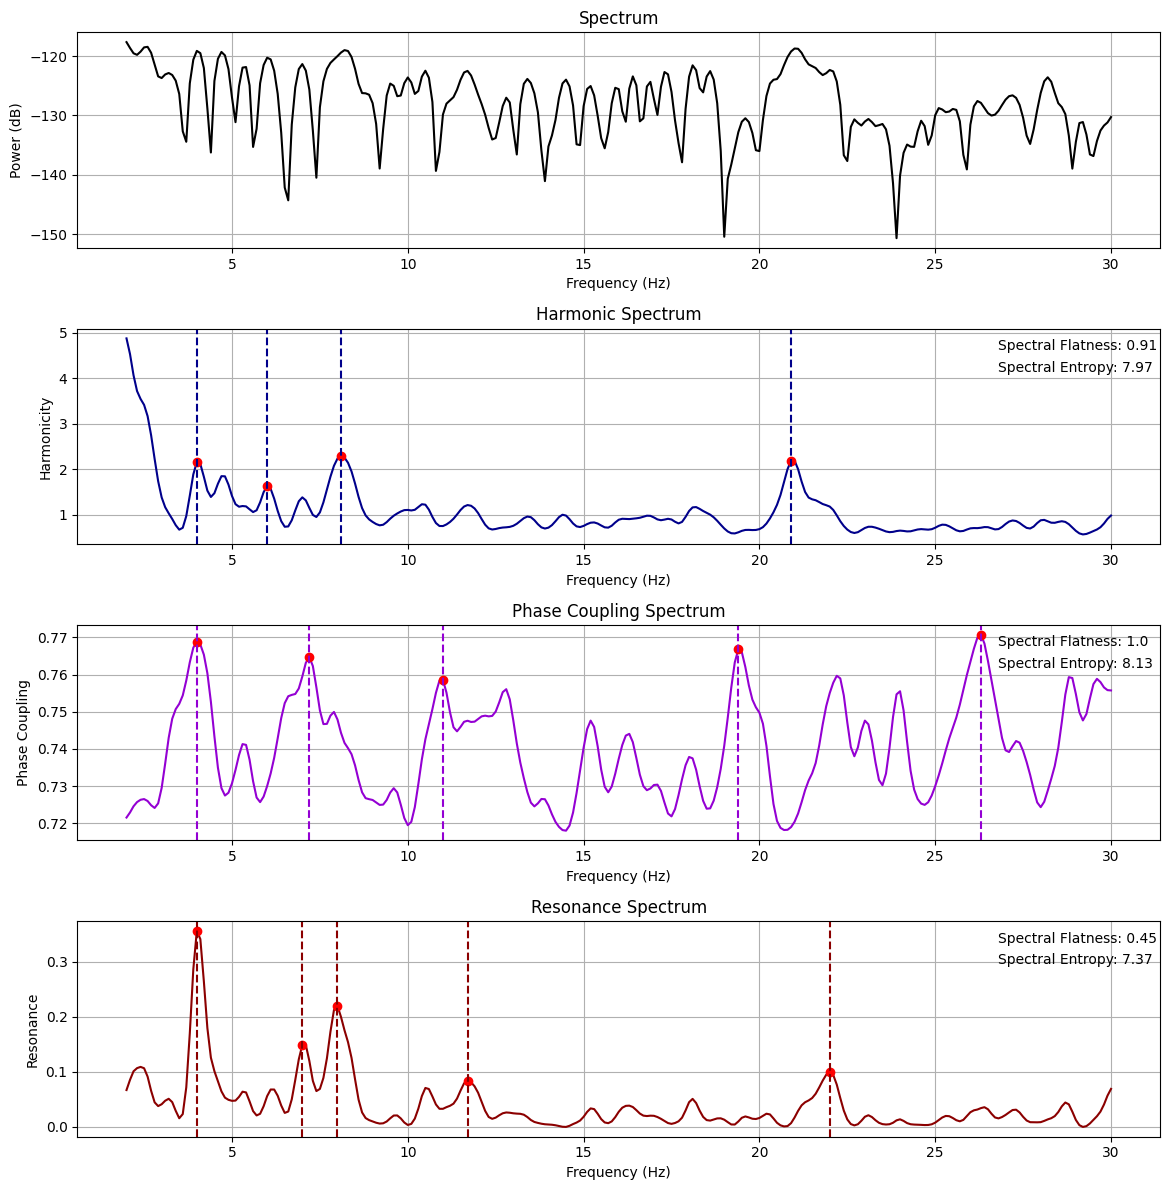

In [58]:
from biotuner.harmonic_spectrum import compute_global_harmonicity
import numpy as np

harm_spectrum_df = compute_global_harmonicity(data[10], 0.1, 2, 30, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=True,
                                             smoothness=1.5, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, phase_mode=None)

### Relation between harmonicity and phase-coupling

We will now look more systematically at the relation between harmonicity and phase-coupling spectrum.

First, let's compute the spectrum for 100 trials in both brain signal and randomly generated signals

In [59]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# compute global harmonicity for multiple trials of EEG data
df_all = []
for i in range(100):
    harm_spectrum_df = compute_global_harmonicity(data[i], 0.1, 2, 30, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=False,
                                             smoothness=1.5, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, save=False, savename='test', phase_mode = None)
    harm_spectrum_df['trial'] = i
    df_all.append(harm_spectrum_df)
    
df_all = pd.concat(df_all, axis=0)
df_brain_norm = df_all.copy()

# generate random signals with shape (104, 4000)
data_rnd = np.random.rand(100, 4000)

# compute global harmonicity for multiple trials of random data
df_all_rnd = []
for i in range(len(data_rnd)):
    harm_spectrum_df_rnd = compute_global_harmonicity(data_rnd[i], 0.1, 2, 30, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=False,
                                             smoothness=1.5, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, save=False, savename='test', phase_mode = None)
    harm_spectrum_df_rnd['trial'] = i
    df_all_rnd.append(harm_spectrum_df_rnd)
    
df_all_rnd = pd.concat(df_all_rnd, axis=0)
df_random_norm = df_all_rnd.copy()

#### Correlation between averaged harmonicity and phase-coupling spectrum for random and brain signals

Brain signals - correlation:  -0.8983308857034057 p-value:  8.77479333479618e-37
Random signals - correlation:  -0.941487410222942 p-value:  4.4122572574174556e-48


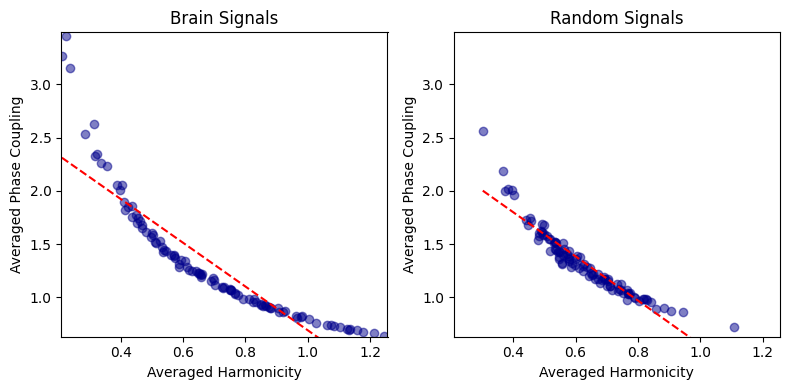

In [197]:
harmonic_spectrum_plot_avg_corr(df_brain_norm, df_random_norm)

*This negative correlation is pretty intense!*

I suspect it might be due to the operation of normalizing my *harmonicity* and *phase-coupling* values by the *total power* (2*total_power).

**It is important to know** that the PSD values used for deriving the total power have been normalized between 0 and 1, preventing drastic effects of power differences between signals.

*However*, we still see this **strong negative correlation**.

It might be driven by the *variability* in total power across signals.

To better investigate, we will look at the correlations ***within trial*** (correlating the values of the *harmonicity* and *phase-coupling spectrum* of all frequencies for each trial), and ***within frequency*** (correlating the harmonicity and phase-coupling values of all the trials for each frequency).


#### Within-trial correlations for random and brain signals

<Figure size 800x400 with 0 Axes>

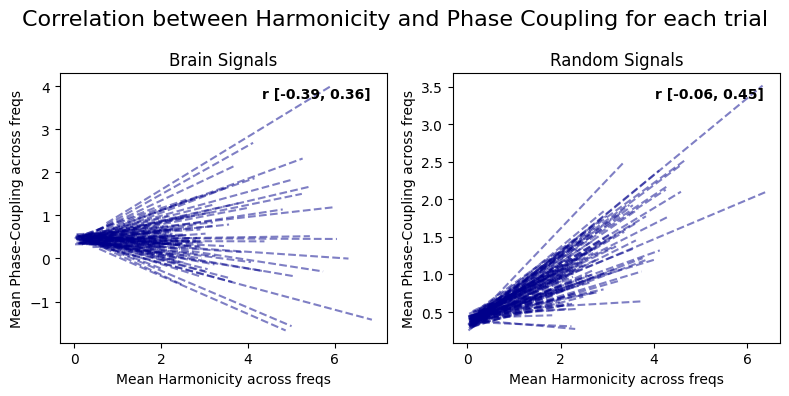

In [183]:
from biotuner.harmonic_spectrum import harmonic_spectrum_plot_trial_corr

harmonic_spectrum_plot_trial_corr(df_brain_norm, df_random_norm)

#### Within-frequency correlations for random and brain signals

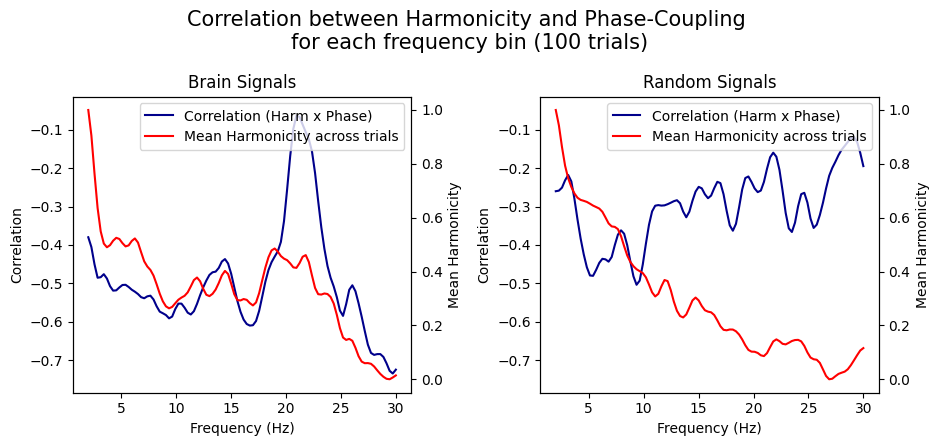

In [182]:
from biotuner.harmonic_spectrum import harmonic_spectrum_plot_freq_corr

harmonic_spectrum_plot_freq_corr(df_brain_norm, df_random_norm, label1='Brain Signals', label2='Random Signals', fmin=2, fmax=30)

In general, the negative correlations across frequencies are much stronger in brain signals than in random signals, suggesting a stronger relationship between harmonicity and phase coupling in brain signals. Moreover, we see that in brain signals, higher harmonicity of a frequency tends to be associated with weaker correlations (specifically salient around 20Hz) while for random signals, we see an opposite trends (lower harmonicity tends to be associated with weaker correlations). Finally, we can observe a systematic decrease of harmonicity with increased in frequency specifically for random signals, while brain signals exhibit clear bumps of harmonicity in higher frequencies.

These results suggest that the relationship between these two measures in the brain signals is different than in the random signals.

#### We will now compare harmonicity and phase-coupling without normalizing the values by the total spectrum power

In [64]:
# compute global harmonicity for multiple trials of EEG data
df_all = []
for i in range(len(data)):
    harm_spectrum_df = compute_global_harmonicity(data[i], 0.1, 2, 30, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=False,
                                             smoothness=1.5, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, save=False, savename='test', phase_mode = None,
                                             harm_phase_norm=False)
    harm_spectrum_df['trial'] = i
    df_all.append(harm_spectrum_df)
    
df_all = pd.concat(df_all, axis=0)
df_brain_no_norm = df_all.copy()

# generate random signals with shape (104, 4000)
data_rnd = np.random.rand(100, 4000)

# compute global harmonicity for multiple trials of random data
df_all_rnd = []
for i in range(len(data_rnd)):
    harm_spectrum_df_rnd = compute_global_harmonicity(data_rnd[i], 0.1, 2, 30, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=False,
                                             smoothness=1.5, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, save=False, savename='test', phase_mode = None,
                                             harm_phase_norm=False)
    harm_spectrum_df_rnd['trial'] = i
    df_all_rnd.append(harm_spectrum_df_rnd)
    
df_all_rnd = pd.concat(df_all_rnd, axis=0)
df_random_no_norm = df_all_rnd.copy()

#### Correlation between averaged harmonicity and phase-coupling spectrum for random and brain signals

Brain signals - correlation:  -0.05521894207526455 p-value:  0.5777024016147708
Random signals - correlation:  0.05652823797505156 p-value:  0.5687008983119215


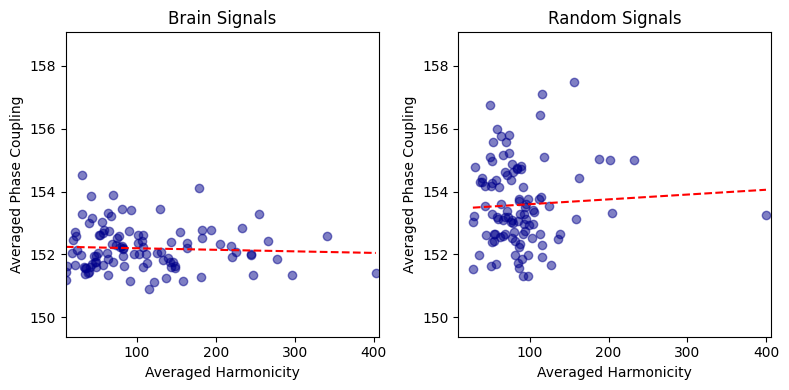

In [201]:
harmonic_spectrum_plot_avg_corr(df_brain_no_norm, df_random_no_norm)

#### Within-trial correlations for random and brain signals

<Figure size 800x400 with 0 Axes>

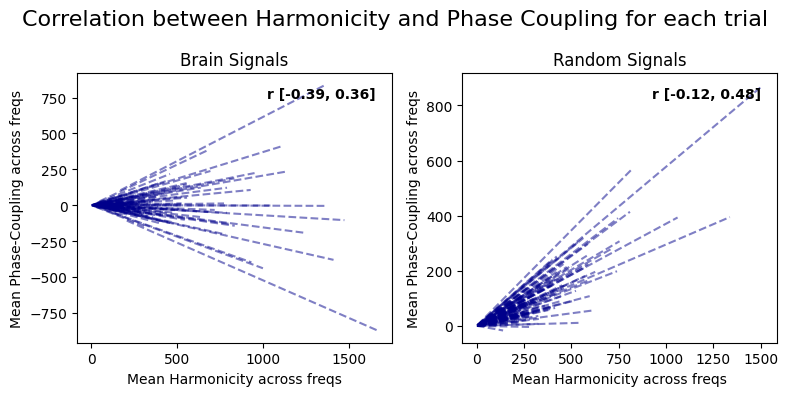

In [180]:
harmonic_spectrum_plot_trial_corr(df_brain_no_norm, df_random_no_norm)

#### Within-frequency correlations for random and brain signals

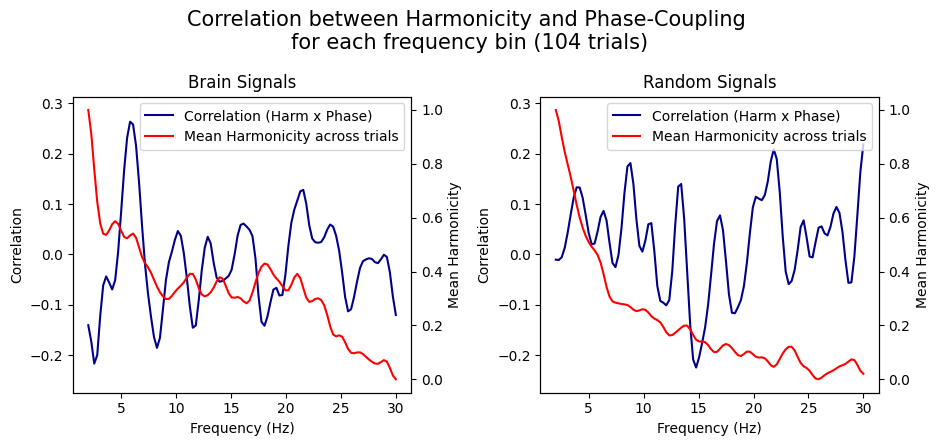

In [ ]:
harmonic_spectrum_plot_freq_corr(df_brain_no_norm, df_random_no_norm, label1='Brain Signals', label2='Random Signals', fmin=2, fmax=30)
